# Stochastic Volatility model

In [1]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy.sparse import csc_matrix
from scipy import optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [2]:
n = 400
returns = np.genfromtxt("data/SP500.csv")[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

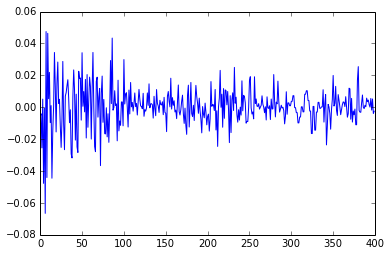

In [3]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [4]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.T('r', nu, lam=pm.exp(-2*s), observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. However, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect to the volatility process, 's', keeping `log_sigma` and `nu` constant at their default values. 

We use L-BFGS because it is more efficient for high dimensional functions (`s` has n elements).

In [5]:
with model:
    start = pm.find_MAP(vars=[s], fmin=optimize.fmin_l_bfgs_b)

We do a short initial run to get near the right area, then start again using a new Hessian at the new starting point to get faster sampling due to better scaling. We do a short run since this is an interactive example.

In [6]:
with model:
    step = pm.NUTS(vars=[s, nu,sigma],scaling=start, gamma=.25)
    start2 = pm.sample(100, step, start=start)[-1]

    # Start next run at the last sampled position.
    step = pm.NUTS(vars=[s, nu,sigma],scaling=start2, gamma=.55)
    trace = pm.sample(2000, step, start=start2)

 [-----------------100%-----------------] 2000 of 2000 complete in 61.4 sec

/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


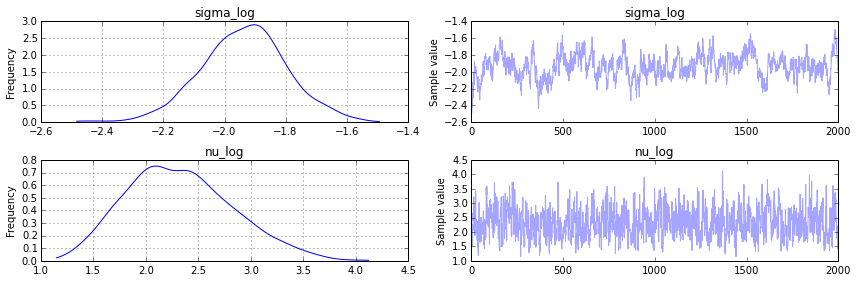

In [7]:
figsize(12,6)
pm.traceplot(trace, model.vars[:-1]);

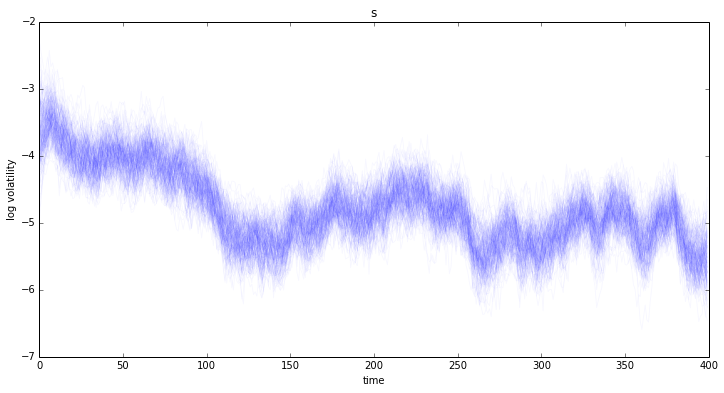

In [10]:
figsize(12,6)
title(str(s))
plot(trace[s][::10].T,'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

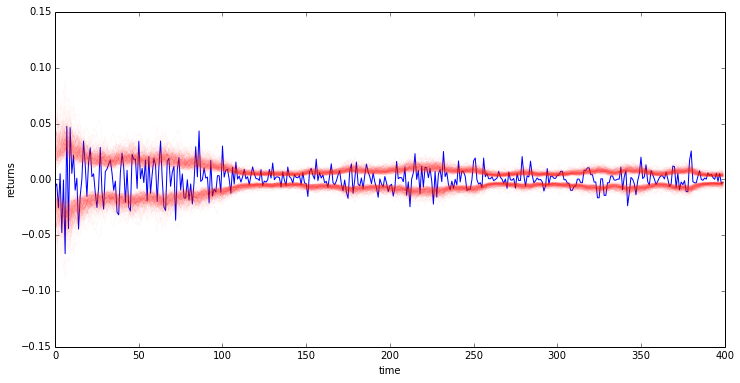

In [9]:
plot(returns)
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
plot(-np.exp(trace[s][::10].T), 'r', alpha=.03);
xlabel('time')
ylabel('returns')

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 